In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
import ISLP
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# from sklearn.tree import (DecisionTreeClassifier as DTC,
#                          DecisionTreeRegressor as DTR,
#                          plot_tree,
#                          export_text)
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import (
    RandomForestRegressor as RFR,
    GradientBoostingRegressor as GBR,
)

# Bagging 随机森林与 Boosting

## Bagging 和随机森林

In [2]:
Boston = load_data("Boston")
model = MS(Boston.columns.drop("medv"), intercept=False)
D = model.fit_transform(Boston)
feature_names = list(D.columns)
X = np.asarray(D)

In [3]:
(X_train, X_test, y_train, y_test) = skm.train_test_split(
    X, Boston["medv"], test_size=0.3, random_state=0
)

在这里，我们使用 `sklearn.ensemble` 包中的 `RandomForestRegressor()` 对 `Boston` 数据集应用 Bagging 和随机森林。回顾一下，Bagging 只是随机森林的一种特殊情况，其中 $m=p$。因此，可以使用 `RandomForestRegressor()` 函数同时执行 Bagging 和随机森林。我们从 Bagging 开始。

In [4]:
bag_boston = RFR(max_features=X_train.shape[1], random_state=42)
bag_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=12, random_state=42)

参数 `max_features` 指定每次划分树时应考虑所有 12 个预测变量——换句话说，这意味着将执行 Bagging。那么，这个 Bagging 模型在测试集上的表现如何呢？

14.685972335526314


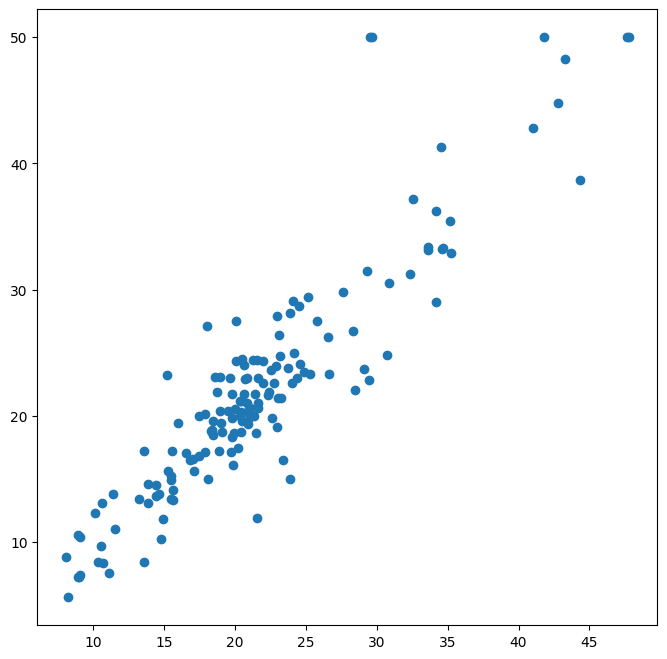

In [5]:
ax = subplots(figsize=(8, 8))[1]
y_hat_bag = bag_boston.predict(X_test)
ax.scatter(y_hat_bag, y_test)

print(mean_squared_error(y_test, y_hat_bag))
plt.show()

与 Bagging 回归树相关的测试集均方误差（MSE）为 14.63，约为使用最佳剪枝单棵树所得误差的一半。我们可以通过使用 `n_estimators` 参数更改生成的树的数量，默认值为 100：

In [6]:
bag_boston = RFR(max_features=X_train.shape[1], n_estimators=500, random_state=42).fit(
    X_train, y_train
)
y_hat_bag = bag_boston.predict(X_test)
print(mean_squared_error(y_test, y_hat_bag))

14.880160788684215


结果变化不大。通过增加树的数量，Bagging 和随机森林不会导致过拟合，但如果树的数量太少，可能会导致欠拟合。

生成随机森林的过程与 Bagging 完全相同，只是我们需要使用较小的 `max_features` 参数值。默认情况下，`RandomForestRegressor()` 在构建随机森林回归树时使用 $p$ 个变量（即默认执行 Bagging），而 `RandomForestClassifier()` 在构建分类树的随机森林时使用 $\sqrt{p}$ 个变量。在这里，我们设置 `max_features=6`。

In [7]:
RF_boston = RFR(max_features=6, random_state=42).fit(X_train, y_train)
y_hat_RF = RF_boston.predict(X_test)
print(mean_squared_error(y_test, y_hat_RF))

18.750761986842104


测试集的均方误差（MSE）为 20.04。

这表明在这种情况下，随机森林的效果略逊于 Bagging。从拟合模型中提取 `feature_importances_` 值，我们可以查看每个变量的重要性。

In [8]:
feature_imp = pd.DataFrame(
    {"importance": RF_boston.feature_importances_}, index=feature_names
)
feature_imp.sort_values(by="importance", ascending=False)

,importance
rm,0.373319
lstat,0.322174
crim,0.071158
indus,0.052837
ptratio,0.048507
dis,0.039479
nox,0.031519
age,0.031088
tax,0.018409
rad,0.005276


这是一个相对度量，表示在所有树中基于某个变量的分裂所导致的节点纯度总减少的平均值（这一结果在针对 `Heart` 数据拟合的模型中绘制于图 8.9）。

结果表明，在随机森林中所有考虑的树中，社区财富水平（`lstat`）和房屋面积（`rm`）是两个最重要的变量。

## 提升方法（Boosting）

在这里，我们使用 `sklearn.ensemble` 中的 `GradientBoostingRegressor()` 来对 `Boston` 数据集拟合提升回归树。对于分类任务，可以使用 `GradientBoostingClassifier()`。参数 `n_estimators=5000` 指定我们希望生成 5000 棵树，而选项 `max_depth=3` 限制了每棵树的深度。参数 `learning_rate` 是之前在提升方法描述中提到的 $\lambda$。

In [9]:
boost_boston = GBR(n_estimators=5000, learning_rate=0.001, max_depth=3, random_state=42)
boost_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=42)

我们可以通过 `train_score_` 属性观察训练误差的减少过程。为了了解测试误差的变化趋势，可以使用 `staged_predict()` 方法获取沿训练路径的预测值。

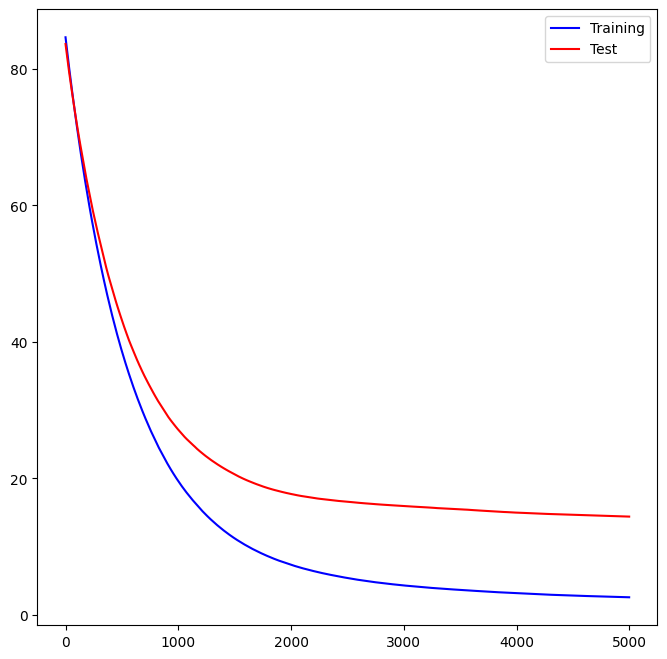

In [10]:
test_error = np.zeros_like(boost_boston.train_score_)
for idx, y_ in enumerate(boost_boston.staged_predict(X_test)):
    test_error[idx] = np.mean((y_test - y_) ** 2)

plot_idx = np.arange(boost_boston.train_score_.shape[0])
ax = subplots(figsize=(8, 8))[1]
ax.plot(plot_idx, boost_boston.train_score_, "b", label="Training")
ax.plot(plot_idx, test_error, "r", label="Test")
ax.legend()

plt.show()

现在我们使用提升模型在测试集上预测 `medv`：

In [11]:
y_hat_boost = boost_boston.predict(X_test)
print(mean_squared_error(y_test, y_hat_boost))

14.400642655478014


测试集的均方误差（MSE）为 14.48，与 Bagging 的测试 MSE 相近。如果需要，我们可以使用不同的缩减参数 $\lambda$ 来执行提升。默认值为 0.001，但可以轻松修改。在这里，我们选择 $\lambda=0.2$。

在这种情况下，使用 $\lambda=0.2$ 得到的测试集均方误差（MSE）与使用 $\lambda=0.001$ 时几乎相同。